### ReAct Agent Architecture

#### Aim
This is the intuition behind ReAct, a general agent architecture.

1. act - let the model call specific tools
2. observe - pass the tool output back to the model
3. reason - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

In [2]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper

In [4]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [23]:
print(arxiv.invoke("Attention is all you need"))

Published: 2024-07-22
Title: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models
Authors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini
Summary: The inference demand for LLMs has skyrocketed in recent months, and serving
models with low latencies remains challenging due to the quadratic input length
complexity of the attention layers. In this work, we investigate the effect of
dropping MLP and attention layers at inference time o


In [5]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
print(wiki.name)

wikipedia


In [24]:
print(wiki.invoke("India"))

Page: India
Summary: India, officially the Republic of India, is a country in South Asia.  It is the seventh-largest country by area; the most populous country since 2023; and, since its independence in 1947, the world's most populous democracy. Bounded by the Indian Ocean on the south, the Arabian Sea on the southwest, and the Bay of Bengal on the southeast, it shares land borders with Pakistan to the west; China, Nepal, and Bhutan to the north; and Bangladesh and Myanmar to the east. In the In


In [7]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEy"] = os.getenv("TAVILY_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACKING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "ReAct-agent"

In [9]:
# Custom functions
def multiply(a:int, b:int)-> int:
    """Multiply a and b.
    
    Args:
    a: first int
    b: second int
    
    """
    return a*b

def add(a:int, b:int)->int:
    """Add a and b.
    
    Args:
    a:first int
    b:second int
    
    """
    return a+b

def divide(a:int, b:int)->float:
    """Divide a and b.
    
    Args:
    a: first int
    b: second int
    """
    return a/b

tools = [arxiv, wiki, add, multiply, divide]

In [10]:
from langchain_tavily import TavilySearch
tavily = TavilySearch()

In [11]:
tavily.invoke("tell me about the recent gst reform in India")

{'query': 'tell me about the recent gst reform in India',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.india-briefing.com/news/india-gst-reform-2025-rate-revisions-list-goods-39619.html/',
   'title': "India's GST Overhaul 2025: Which Goods Get Cheaper & Costlier",
   'content': "3 days ago·India's GST reform 2025 simplifies the tax structure to three slabs – 5 percent, 18 percent, and a new 40 percent de-merit rate – making",
   'score': 0.75809944,
   'raw_content': None},
  {'url': 'https://www.youtube.com/watch?v=WbYHYlnffkQ',
   'title': "GST 2.0 Explained: India's Biggest Tax Reform in a Decade - YouTube",
   'content': "3 days ago·India's GST Council has unveiled GST 2.0—a landmark reform that simplifies tax slabs, reduces rates on essentials, and boosts affordability",
   'score': 0.7152057,
   'raw_content': None},
  {'url': 'https://www.kotakmf.com/Information/blogs/gst-2-point-0_',
   'title': 'GST 2.0: New 5% & 18% Slabs Ef

In [12]:
### Initialize the LLM model

from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

llm_with_tools = llm.bind_tools(tools)

In [14]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

response = llm_with_tools.invoke([HumanMessage(content=f"What is the recent GST Reform in India")])

print(response.tool_calls)

[{'name': 'wikipedia', 'args': {'query': 'GST Reform in India'}, 'id': 'call_Kf27QvDpUQKn46wznENI4wPn', 'type': 'tool_call'}]


In [15]:
# State Schema 
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages:Annotated[list[AnyMessage], add_messages]

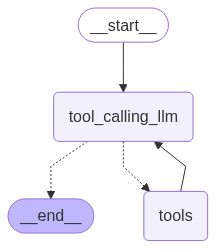

In [27]:
### Chatbot with LangGraph

from IPython.display import display, Image
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from pprint import pprint


# Node definition

def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}


# Build the graph

builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)

builder.add_edge("tools", "tool_calling_llm")

graph = builder.compile()

#View
display(Image(graph.get_graph().draw_mermaid_png()))


In [30]:
messages = graph.invoke({"messages":HumanMessage(content="What is the latest updates on GST report in India, also add 5 plus 5 and then multiply by 10")})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is the latest updates on GST report in India, also add 5 plus 5 and then multiply by 10
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_X0D4GxuxCjrY8w2tAJCRHM9P)
 Call ID: call_X0D4GxuxCjrY8w2tAJCRHM9P
  Args:
    query: Goods and Services Tax (GST) report in India
  add (call_1HQz2GzANopRlcZ2On9FiuCO)
 Call ID: call_1HQz2GzANopRlcZ2On9FiuCO
  Args:
    a: 5
    b: 5
  multiply (call_h432Y3pZx2VTRU3jtF0T71fP)
 Call ID: call_h432Y3pZx2VTRU3jtF0T71fP
  Args:
    a: 10
    b: 10
================================= Tool Message =================================
Name: wikipedia

Page: Goods and Services Tax (India)
Summary: The Goods and Services Tax (GST) is a type of indirect tax which is successor to multiple indirect taxes prevailing in India before 1 July 2017 for example VAT, Service Tax, Central Excise Duty, Entertainment Tax, Octroi, etc

In [29]:
messages = graph.invoke({"messages":HumanMessage(content="I want to learn Machine Learning!")})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

I want to learn Machine Learning!
================================== Ai Message ==================================

That's great! Machine Learning (ML) is a fascinating and rapidly evolving field. Here are some steps you can follow to get started:

1. **Understand the Basics**:
   - Start with understanding what machine learning is, the different types of machine learning (supervised, unsupervised, and reinforcement learning), and common terminology.

2. **Mathematics Background**:
   - A solid understanding of statistics, linear algebra, calculus, and probability is crucial as these areas form the foundation of many ML algorithms.

3. **Programming Skills**:
   - Learn a programming language commonly used in ML, such as Python or R. Python is particularly popular due to its libraries and community support.

4. **Explore ML Libraries**:
   - Familiarize yourself with ML libraries such as Scikit-learn, Ten